# Data Assimilation

In this lab we are interested in reconstructing the "best" estimate of the state of an object given an imperfect physical model of its dynamics and a set of noisy observations. How should we weight our trust in physics against actual data? The field of **data assimilation** attempts to answer these questions. 

Data assimilation is useful for: 
1. Optimizing the accuracy or models when making predictions. Data assimilation is the backbone of modern weather forecasting. 
2. Finding *physically consistent* states that agree with observations. If a model predicts observations *and* obeys the laws of physics, we can analyze modeled quantities like energy transfer, angular momentum, etc.
3. Formally testing physical models to see if they are statistically consistent with data. Data assimilation can tell us whether model-data disagreements are due to observational noise and model uncertainty or unidentified errors in the underlying dynamical model (i.e., "missing physics").   

## Part 1: The physical model 

Today we will assume that our object's position is governed by a damped, forced harmonic oscillator
\begin{equation}
\frac{\mathrm{d}^2 x}{\mathrm{d}t^2} + \gamma \frac{\mathrm{d} x}{\mathrm{d}x} + \omega_0^2 x = f(t) \tag{1}
\end{equation}
where $\gamma$ is the damping factor and $\omega_0$ is the natural frequency. The unknown forcing, $f(t)$, may represent unmeasured external force or an error in forces on the left-hand-side. It could account for an error in $\omega_0$, the fact that damping should be quadratic rather than linear, or just a truncation error from the numerical method.

### Numerical solutions

Data assimilation is *computationally expensive*. Typically, the dynamical system must be solved forward and backward(!) with slightly different forcing for every observational point. For example, if we make 500 observations, we will need to solve the model 1,000 times. Luckily, we learned how to solve linear systems with different forcing very efficiently a few weeks back (remember?). 
1. Discretize the model time grid as $t_n = n \Delta t$ for $n=0,1,2,...N$.
2. Write (1) as $\mathbf{A}\mathbf{x}=\mathbf{f} $ where $\mathbf{A}$ is a matrix encoding all the dynamics, $\mathbf{x}$ is the **state vector** with $x_n=x(t_n)$, and $\mathbf{f}$ is the **external forcing vector** with $f_n=f(t_n)$. 
3. Compute the LU decomposition of $\mathbf{A}$, so that we can solve (1) for any forcing vector using a quick back-substitution. 

How do we write a time-dependent problem like (1) as a linear system? Discretize (1) using centered differences
\begin{equation}
\frac{x_{n+1} - 2x_n + x_{n-1}}{\Delta t^2}+ \gamma\,\frac{x_{n+1} - x_{n-1}}{2\Delta t}+ \omega_0^2 x_n= f_n \tag{2}
\end{equation}
Then solve for $x_{n+1}$ in terms of $x_n$, $x_{n-1}$, and $f_n$. Writing the equation for each time step as a row in the matrix yields:

\begin{equation}
\begin{bmatrix}
? & ? & ? & ? & ? & \cdots & ? \\ 
? & ? & ? & ? & ? & \cdots & ? \\ 
\frac{1}{\Delta t^2} - \frac{\gamma}{2\Delta t} & -\frac{2}{\Delta t^2} + \omega_0^2 & \frac{1}{\Delta t^2} + \frac{\gamma}{2\Delta t} & 0 & 0 & \cdots & 0 \\ 
0 & \frac{1}{\Delta t^2} - \frac{\gamma}{2\Delta t} & -\frac{2}{\Delta t^2} + \omega_0^2 & \frac{1}{\Delta t^2} + \frac{\gamma}{2\Delta t} & 0 & \cdots & 0 \\ 
0 & 0 & \frac{1}{\Delta t^2} - \frac{\gamma}{2\Delta t} & -\frac{2}{\Delta t^2} + \omega_0^2 & \frac{1}{\Delta t^2} + \frac{\gamma}{2\Delta t} & \cdots & 0 \\ 
\vdots & \ddots & \ddots & \ddots & \ddots & \ddots & \vdots \\ 
0 & \cdots & 0 & \frac{1}{\Delta t^2} - \frac{\gamma}{2\Delta t} & -\frac{2}{\Delta t^2} + \omega_0^2 & \frac{1}{\Delta t^2} + \frac{\gamma}{2\Delta t} & 0 \\ 
0 & \cdots & 0 & 0 & \frac{1}{\Delta t^2} - \frac{\gamma}{2\Delta t} & -\frac{2}{\Delta t^2} + \omega_0^2 &  \frac{1}{\Delta t^2} + \frac{\gamma}{2\Delta t} 
\end{bmatrix}
\begin{bmatrix}
x_0 \\[1mm]
x_1 \\[1mm]
x_2 \\[1mm]
x_3 \\[1mm]
x_4 \\[1mm]
\vdots \\[1mm]
x_{N-1} \\[1mm]
x_N
\end{bmatrix}
=
\begin{bmatrix}
? \\[1mm]
f_0+? \\[1mm]
f_1 \\[1mm]
f_2 \\[1mm]
f_3 \\[1mm]
\vdots \\[1mm]
f_{N-2} \\[1mm]
f_{N-1}
\end{bmatrix}. \tag{3}
\end{equation}

Notice a few things:
1. The matrix looks slightly different that it did when we solved the Poisson equation (a boundary value problem). The entries are shifted down one diagonal. This is because we have two initial conditions instead of a boundary condition for the first and last row.  
2. The $f_n$ index lags the $x_n$ index because the present forcing determines the next state.
3. We can't compute $x_0$ or $x_1$ with our formula, hence the "?"s. We need the initial conditions two construct the first two equations. 

### Imposing the initial conditions

The state vector $\mathbf{x}$ starts at the known initial position, $x_0$. We impose this with the top row by simply setting $A_{11}=1$ and $f_{-1}=x_0$ (note that $f_{-1}$ is the top row in $\mathbf{f}$, because it is offset by one with $\mathbf{x}$). The known initial velocity is $v_0\approx (x_1-x_{-1})/(2\Delta t)$. Solving for the missing "ghost point" yields
\begin{equation}
x_{-1}=x_1-2\Delta t v_0 \tag{4}
\end{equation}
So, the second row can be constructed using the usual formula (2), but with the $x_{-1}$ term represented by a combination of $x_1$ and external forcing proportional to $2\Delta t v_0$. Specifically, the $x_0$ coefficients are the usual $A_{21}=-2/\Delta t^2 + \omega_0^2$, but the $x_1$ coefficients include extra terms for the ghost point ($x_{-1}$),
\begin{equation}
A_{22}=\left(\frac{1}{\Delta t^2} + \frac{\gamma}{2\Delta t}\right)+\left(\frac{1}{\Delta t^2} - \frac{\gamma}{2\Delta t}\right) \tag{5}
\end{equation}
and forcing vector includes both the actual forcing at $t=0$ and the extra coefficients for the ghost point
\begin{equation}
f_0= f(0)+\left(\frac{1}{\Delta t^2} - \frac{\gamma}{2\Delta t}\right) 2 \Delta t v_0 \;. \tag{6}
\end{equation}

## Task 1: Solve the numerical model

Write a function that computes $\mathbf{A}$. Then specify $\mathbf{f}_0$ with initial conditions $x_0$ and $v_0$, but no external forcing (i.e., $f(t)=0$) and solve $\mathbf{A}\mathbf{x}_F=\mathbf{f}_0$ for $\mathbf{x}_F$ using a built-in numpy linear-algebra routine. We will refer to this as the "forward model" because it runs forward in time without any data assimilation.

## Task 2: Compare the numerical solution to the analytical solution

I'm sure you recall there is an exact solution to (1) when $f(t)=0$, which is
\begin{equation}
x(t) = e^{-\frac{\gamma t}{2}} \left[ x_0 \cos(\omega t) + \frac{v_0 + \frac{\gamma}{2}x_0}{\omega} \sin(\omega t) \right] \tag{7}
\end{equation}
where $\omega = \sqrt{\omega_0^2 - \gamma^2/4}$. This is a convenient test for the numerical solution. Write a function that computes this solution, then plot it against your numerical solution. 


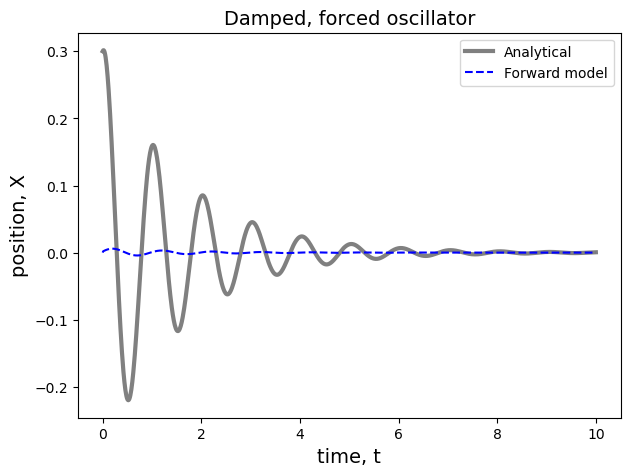

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
T=10
N=1000
omega0=2*np.pi;
gamma=omega0/5.0
x0=.3
v0=.2

# Time grid
t=np.linspace(0,T,N)
dt=t[1]-t[0]

# Define the analytical solution for a weakly damped oscillator
def calc_theory(t,omega0,gamma):    
    # YOUR CODE HERE
    omega = np.sqrt(omega0**2 - (gamma**2)/4)
    x = np.exp(-gamma*t/2)*(x0*np.cos(omega*t) + (v0 + (gamma/2)*x0)/omega * np.sin(omega*t))
    return x

# Define the linear operator A so that the damped harmonic oscillator is Ax=f
def calc_A(t,omega0,gamma):
    
    # Compute N and dt
    N=len(t)
    dt=t[1]-t[0]

    # Initiate A
    A=np.zeros((N,N))

    # 1st equation is just x0=x0 
    # YOUR CODE HERE
    A[0,0] = 1.0
    
    # 2nd equation uses v0 to specify the ghost point x_{-1}
    # YOUR CODE HERE
    a_minus = 1/dt**2 - gamma/(2*dt)
    a_0 = -2/dt**2 + omega0**2
    a_plus = 1/dt**2 + gamma/(2*dt)
    A[1,0] = a_0
    A[1,1] = a_plus + a_minus

    # Define the rest of the equations using centered differences 
    # YOUR CODE HERE
    for n in range(2, N):
        A[n,n-1] = a_minus
        A[n,n] = a_0
        if n< N-1:
            A[n,n+1] = a_plus
    return A

# Define the forcing vector
f=np.zeros(N)

# 1st equation is just x0=x0 
# YOUR CODE HERE
a_minus = 1/dt**2 - gamma/(2*dt)
f[1] = a_minus * (2*dt*v0)
# 2nd equation uses v0 to specify the ghost point x_{-1}
# YOUR CODE HERE

# Run the model by solving a linear system Ax=f
#xF=???? # YOUR CODE HERE
A = calc_A(t,omega0,gamma)
xF = np.linalg.solve(A,f)
  
x_theory=calc_theory(t,omega0,gamma)
   
# Plot
fig = plt.figure(1,figsize=(7, 5), dpi=100)
plt.clf()
ax = fig.gca()
plt.plot(t,x_theory,'-',color='gray',label='Analytical',linewidth=3)
plt.plot(t,xF,'b--',label='Forward model')
plt.title(r'Damped, forced oscillator', fontsize=14)
plt.xlabel('time, t', fontsize=14)
plt.ylabel('position, X', fontsize=14)

plt.legend(loc='upper right')

plt.show()


## Part 2: The Observations 

Making an observation essentially "measures" the true state vector, $\mathbf{x}_T$, in some way and adds error. We will make $M$ observations, $m=1,2,... M$. Mathematically, the $m$-th observation is 
\begin{equation}
d_m = \mathbf{L}_m \mathbf{x} + \epsilon_m \tag{8}
\end{equation}
where $\mathbf{L}_m$ is a *measurement operator* and $\epsilon_m$ is the error. The error is due to uncertainties in the measurement process and the precision of the instrument. Usually, $\epsilon_m \sim \mathcal{N}(0,\sigma_d^2)$ is attributed to "noise" and is modeled as independent Gaussian random variable with zero mean and variance $\sigma_d^2$. This assumption greatly simplifies statistical analysis, but is not always correct because many instruments have errors that are systematic and correlated (e.g., consider a temperature sensor that is out of calibration). 

The exact nature of the measurement operator depends on how we measure the state. If the $m$-th observation is simply the position at time $t_n$ then $\mathbf{L}_m$ is just a $[1 \times N]$ row vector of zeros with a 1 in the $n$-th column. On the other hand, if we measure *velocity* at time $t_n$, then $\mathbf{L}$ should have a $1/2\Delta t$ in the $n+1$ column and a $-1/2\Delta t$ in the $n-1$ column, so that  
\begin{equation}
\mathbf{L}_m \mathbf{x} = \frac{x_{n+1}-x_{n-1}}{2 \Delta t} \approx v_m \tag{9}
\end{equation}
Alternatively, if we average position over times $t=[t_1\;, t_5]$, then $\mathbf{L}_m$ is defined so that
\begin{equation}
\mathbf{L}_m \mathbf{x} = \frac{x_1+x_2+x_3+x_4+x_5}{5} = \overline{x}_m \tag{10}
\end{equation}
Many other measurement operators are possible, and for sophisticated instruments $\mathbf{L}_m$ is likely to be complicated and nonlinear. Consider how voltages from sensors at LIGO are related to a gravitational wave, or how voltages from sensors in an MRI machine are related to tissue density. Here, we will consider only linear measurement operators. Stacking the $M$ operators together produces the *measurement matrix* $\mathbf{L}$, so that all the observations are computed from
\begin{equation}
\mathbf{d} = \mathbf{L}\mathbf{x} + \boldsymbol{\epsilon} \tag{11}
\end{equation}
Note that $\mathbf{L}$ is $[M \times N]$, because it converts the $[N \times 1]$ *state vector* into a $[M \times 1]$ *data vector*. 

## Task: Create a synthetic dataset

Since we don't have any real data, today we will make *synthetic* observations by defining an interesting "true forcing", $\mathbf{f}_T$. The exact form is immaterial, but I have coded a function with two Gaussian peaks, and you are free to alter their locations, heights, and widths. The overall amplitude of the true forcing is set by $\sigma_F$, which we can interpret as the amplitude of the "forcing error". For real observations, one doesn't know $\sigma_F$, but instead attempts to estimate it from the errors in parameters, dynamical approximations, etc. A simple and rather large guess might be $\sigma_F\approx\omega_0^2 |x_0|$, that is, the unknown errors are roughly the same amplitude as the restoring force at $t=0$. Once we have specified the "true force", we can determine the "true state", $\mathbf{x}_T$ by solving $\mathbf{A}\mathbf{x}_T = \mathbf{f}_0+\mathbf{f_T}$.

Our synthetic observations are obtained from the true state in four steps:

1. Pick $M$ random time indices to measure between $0$ and $N$. You could also try $M$ regularly spaced indices if you envision an orderly measurement process. 

2. Use the indices to find the times of the measurements so that you can plot them later.

3. Define a measurement operator, $\mathbf{L}$, such that $\mathbf{d}=\mathbf{L}\mathbf{x}$ is a vector of (perfect) observations at the $M$ random locations.

4. Compute $\mathbf{d}$ by measuring the true state vector and adding random error, $\boldsymbol{\epsilon}$ (see eq. 11). 

Plot the true state, forward model, and observations. Lastly, experiment with how altering $\sigma_d$, $\sigma_f$, and $\sigma_T$ change the true solution and observations. 


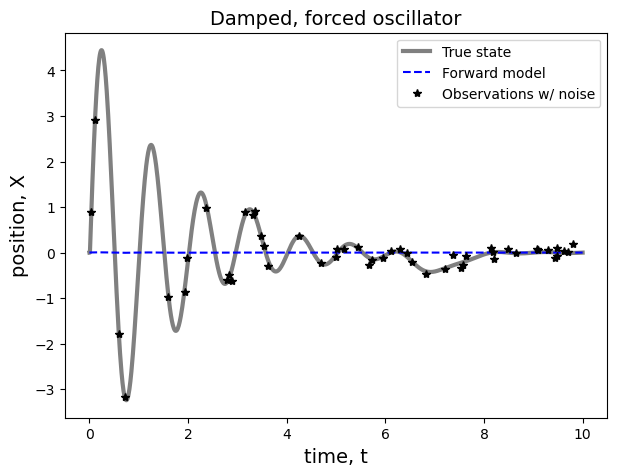

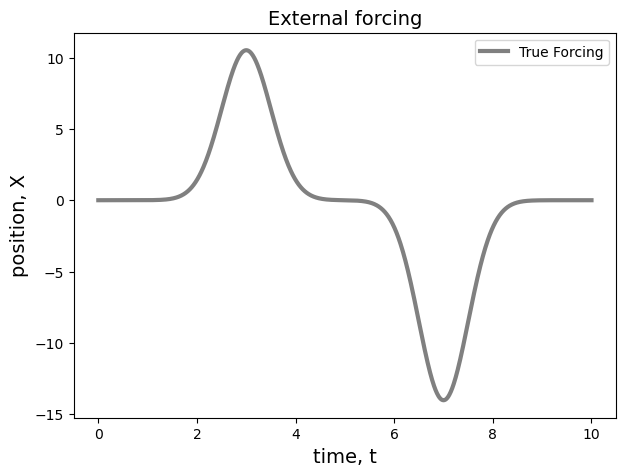

In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(5)


################################################################################
# Define a true state to "observe"

# Set the overall amplitude of the forcing correction
sigmaF=0.5*abs(x0)*omega0**2 

# Set the width fo the peaks (in time)
sigmaT=0.5*(2*np.pi/omega0) 

# Define the "true forcing"
fT=sigmaF**2*(0.3*np.exp(-1/2*((t-0.3*T)/sigmaT)**2)-0.4*np.exp(-1/2*((t-0.7*T)/sigmaT)**2))

# Use the true forcing to define a "true state"
#xT=??? # YOUR CODE HERE
f_true = f.copy()
f_true[2:] += fT[:-2]

xT = np.linalg.solve(A, f_true)
################################################################################
# Create a synthetic dataset from the true state

# Number of observations
M=50

# Standard deviation of observation noise
sigmaD=.1

# Define the observation operator:
# 1. pick M random indices to sample between 0 and N
# YOUR CODE HERE
obs_idx = np.sort(np.random.choice(N, M, replace=False))
# 2. find the times of the observations
# YOUR CODE HERE
to = t[obs_idx]
# 3. Compute the matrix L such that d=Lx is a vector of observations at the M random locations 
# YOUR CODE HERE
L = np.zeros((M, N))
for i, n in enumerate(obs_idx):
    L[i, n] = 1.0
# 4. Measure the state and add Gaussian noise with standard deviation sigmaD
# YOUR CODE HERE
noise = sigmaD * np.random.randn(M)
d = L @ xT + noise
# Plot
fig = plt.figure(1,figsize=(7, 5), dpi=100)
plt.clf()
ax = fig.gca()
plt.plot(t,xT,'-',color='gray',label='True state',linewidth=3)
plt.plot(t,xF,'b--',label='Forward model')
plt.plot(to,d,'k*',label='Observations w/ noise',ms=6)
plt.title(r'Damped, forced oscillator', fontsize=14)
plt.xlabel('time, t', fontsize=14)
plt.ylabel('position, X', fontsize=14)

plt.legend(loc='upper right')

plt.show()

fig = plt.figure(2,figsize=(7, 5), dpi=100)
plt.clf()
ax = fig.gca()
plt.plot(t,fT,'-',color='gray',label='True Forcing',linewidth=3)
plt.title(r'External forcing', fontsize=14)
plt.xlabel('time, t', fontsize=14)
plt.ylabel('position, X', fontsize=14)

plt.legend(loc='upper right')

plt.show()


## Part 3: Data Assimilation

We now have a model and observational data. The forward model is not very good (see above!) and the observations are too noisy and sparse to simply interpolate (see above!). That's okay, we can use our scientific knowledge (sometimes called "domain knowledge" in the AI community) to optimally combine our results. We will seek the *generalized inverse* solution:
\begin{align}
\mathbf{x}_I=\mathbf{x}_F+\mathbf{x}_c && \mathrm{and} && \mathbf{f}_I=\mathbf{f}_0+\mathbf{f}_c \tag{12}
\end{align}
where $\mathbf{x}_c$ is a *correction* to the forward model, such that (1) becomes
\begin{align}
\mathbf{A}\left(\mathbf{x}_F+\mathbf{x}_c\right)=\left(\mathbf{f}_0+\mathbf{f}_c\right) \tag{14}
\end{align}
and the *forward solution*, $\mathbf{x}_F$, and its *correction*, $\mathbf{x}_c$, are determined by
\begin{align}
\mathbf{A}\mathbf{x}_F=\mathbf{f}_0 && \mathrm{and} && \mathbf{A}\mathbf{x}_c=\mathbf{f}_c \tag{15} \;.
\end{align}
Our correction will optimally adjust the forcing *before* and after each observation to achieve the best overall state between time $t=0$ and $t=T$. This is sometimes called "smoothing" or "reanalysis", it must be done after all the observations are collected. Conversely, real-time prediction models often use "sequential" data assimilation where new data is only used to update the model going forward, and no attempt is made to adjust the history of the model. This is called "filtering", which is useful in the engineering field of "control theory", where robots must blend inputs from sensors with predictive models. See for example, the "Kalman filter".

The inverse solution, $\mathbf{x}_I$, and associated forcing correction, $\mathbf{f}_c$, minimize the **objective function**, also known as the **cost function**, **loss function**, or **penalty function**, given by:
\begin{align}
\mathcal{J}(\mathbf{x}) &= \frac{1}{2} \mathbf{f}_c^T \mathbf{C}_f^{-1} \mathbf{f}_c + \frac{1}{2} \left(\mathbf{d}-\mathbf{L}\mathbf{x}\right)^T \mathbf{C}_d^{-1} \left(\mathbf{d}-\mathbf{L}\mathbf{x}\right) \nonumber \\
&= \frac{1}{2} \left(\mathbf{A}\mathbf{x}-\mathbf{f}_0\right)^T \mathbf{C}_f^{-1} \left(\mathbf{A}\mathbf{x}-\mathbf{f}_0\right) + \frac{1}{2} \left(\mathbf{d}-\mathbf{L}\mathbf{x}\right)^T \mathbf{C}_d^{-1} \left(\mathbf{d}-\mathbf{L}\mathbf{x}\right) \tag{16}
\end{align}
where $\mathbf{C}_f^{-1}$ is a symmetric $[N \times N]$ "model weight matrix" and $\mathbf{C}_d^{-1}$ is a symmetric $[M \times M]$ "data weight matrix". The cost function is positive semi-definite and grows with the magnitude of the forcing correction $\mathbf{f}_c$ and data-observation mismatch $\mathbf{d}-\mathbf{L}\mathbf{x}$. Since we can adjust $\mathbf{f}_c$ to improve the model, it is referred to as a "control variable". Other objective functions are possible with different control variables that seek to minimize corrections to initial conditions, boundary conditions, parameters such as $\omega_0$, etc. In our case, if the forward model already predicts the observations perfectly, then $\mathcal{J}=0$ because the inverse solution is simply $\mathbf{x}=\mathbf{x}_F$, which produces $\mathbf{d}-\mathbf{L}\mathbf{x}=0$ and $\mathbf{f}_c=0$. 

In general, the model and data disagree, so both terms are non-zero and their relative sizes are governed by the "weight" matrices. It should be somewhat intuitive that the weights are inversely proportional to the errors. It turns out $\mathbf{C}_f$ and $\mathbf{C}_d$ are the forcing-error and data-error covariances, respectively. Since, the data errors, $\epsilon_m$, were assumed independent, $\mathbf{C}_d$ is just a matrix with the $\sigma_d^2$ down the diagonal. 

Specifying the forcing-error covariance, $\mathbf{C}_f$, is a little harder. The general magnitude should be $\sigma_f^2$, as discussed above, but we can't use a diagonal matrix. Why? Because if the forcing at time $t_n$ and $t_{n+1}$ is completely uncorrelated, then the forcing correction with the smallest magnitude (L$_2$ norm) will be zero everywhere except at the exact times of the observations, where it will have spikes. That is, the forcing will "surgically" correct model so that it exactly matches the observations, while avoiding any other changes. 

Physically, we expect the forcing correction to be as smooth as the (unkown) external forces or errors in dynamics (e.g., the impact of using linear drag instead of quadratic drag). The simplest solution is to specify a Gaussian covariance with a width of $\sigma_T$ that can be used to adjust the smoothness of the forcing correction. Other, spatial forms of covariances are possible and often necessary (e.g., we wouldn't expect currents on the east and west coasts of Panama to covary just because they are separated by a small distance, they are in completely different oceans!). In practice, forcing corrections and inverse solutions tend to be insensitive to $\sigma_T$, provided it is roughly similar to the timescale of the true forcing. 

Before attempting to minimize $\mathcal{J}(\mathbf{x})$ it is useful to consider it's behavior in extreme cases: 
1. Perfect dynamics: If the model is perfect, then $\sigma_f^2\ll1$, the error-covariance ($\mathbf{C}^f$) is tiny, and its inverse (the weight in 16) is huge. Even a tiny forcing correction sill "blow up" the cost function. Hence, $\mathbf{f}_c$ is zero and we attribute all mode-data mismatch to observational errors and make no attempt to minimize them. 
2. Perfect observations: If the data are perfect, then $\sigma_d^2\ll1$, the error-covariance ($\mathbf{C}^d$) is tiny, and its inverse (the weight in 16) is huge. The corrected model must match the observations perfectly. Hence, $\mathbf{f}_c$ can be arbitrarily tuned until the model passes directly through every data point. We attribute all error to poorly-known dynamics. 

### Minimzing the objective function 

The objective function, $\mathcal{J}(\mathbf{x})$, is a quadratic function in $N$ dimensions. To find it's minimum, we must take the derivative in every dimension and set it to zero. There are slick methods involving vector derivatives, but they depend on memorizing conventions for row vs column operations (see "Matrix calculus" on Wikipedia). Instead, we will find set the differential to zero for small variations $\delta \mathbf{x}$:  
\begin{align}
\delta\mathcal{J} &= \mathcal{J}\left(\mathbf{x}+\delta\mathbf{x}\right)-\mathcal{J}\left(\mathbf{x}\right) \nonumber\\
&= \frac{1}{2} \left[\mathbf{A}\left(\mathbf{x}+\delta\mathbf{x}\right)-\mathbf{f}_0\right]^T \mathbf{C}_f^{-1} \left[\mathbf{A}\left(\mathbf{x}+\delta\mathbf{x}\right)-\mathbf{f}_0\right] + \frac{1}{2} \left[\mathbf{d}-\mathbf{L}\left(\mathbf{x}+\delta\mathbf{x}\right)\right]^T \mathbf{C}_d^{-1} \left[\mathbf{d}-\mathbf{L}\left(\mathbf{x}+\delta\mathbf{x}\right)\right] - \frac{1}{2} \left[\mathbf{A}\mathbf{x}-\mathbf{f}_0\right]^T \mathbf{C}_f^{-1} \left[\mathbf{A}\mathbf{x}-\mathbf{f}_0\right] - \frac{1}{2} \left[\mathbf{d}-\mathbf{L}\mathbf{x}\right]^T \mathbf{C}_d^{-1} \left[\mathbf{d}-\mathbf{L}\mathbf{x}\right]2\nonumber\\
&=\frac{1}{2} \left(\mathbf{A}\delta\mathbf{x}\right)^T \mathbf{C}_f^{-1} \left(\mathbf{A}\mathbf{x}-\mathbf{f}_0\right) + \frac{1}{2}\left(\mathbf{A}\mathbf{x}-\mathbf{f}_0\right)^T \mathbf{C}_f^{-1} \left(\mathbf{A}\delta\mathbf{x}\right)-\frac{1}{2} \left(\mathbf{L}\delta\mathbf{x}\right)^T \mathbf{C}_d^{-1} \left(\mathbf{d}-\mathbf{L}\mathbf{x}\right)-\frac{1}{2} \left(\mathbf{d}-\mathbf{L}\mathbf{x}\right)^T \mathbf{C}_d^{-1} \left(\mathbf{L}\delta\mathbf{x}\right) +\mathcal{O}\left(\delta\mathbf{x}^2\right)\nonumber\\
&= \frac{1}{2} \delta\mathbf{x}^T \mathbf{A}^T \mathbf{C}_f^{-1} \left(\mathbf{A}\mathbf{x}-\mathbf{f}_0\right) + \left[\frac{1}{2}\left(\mathbf{A}\mathbf{x}-\mathbf{f}_0\right)^T \mathbf{C}_f^{-1} \left(\mathbf{A}\delta\mathbf{x}\right)\right]^T-\frac{1}{2} \delta\mathbf{x}^T\mathbf{L}^T \mathbf{C}_d^{-1} \left(\mathbf{d}-\mathbf{L}\mathbf{x}\right)-\left[\frac{1}{2} \left(\mathbf{d}-\mathbf{L}\mathbf{x}\right)^T \mathbf{C}_d^{-1} \left(\mathbf{L}\delta\mathbf{x}\right) \right]^T +\mathcal{O}\left(\delta\mathbf{x}^2\right)\nonumber\\
&= \delta\mathbf{x}^T \mathbf{A}^T \mathbf{C}_f^{-1} \left(\mathbf{A}\mathbf{x}-\mathbf{f}_0\right) - \delta\mathbf{x}^T\mathbf{L}^T \mathbf{C}_d^{-1} \left(\mathbf{d}-\mathbf{L}\mathbf{x}\right) +\mathcal{O}\left(\delta\mathbf{x}^2\right)\nonumber
 \end{align}
where the second line expanded the objective function, the third line canceled a bunch of terms and collected the higher-order terms into $\mathcal{O}\left(\delta\mathbf{x}^2\right)$, and the fourth line recognized that the quadratic forms are really just scalars, so are equal to their transpose. The fifth line uses the transpose rules and the fact that $\mathbf{C}_f^{-1}$ and $\mathbf{C}_d^{-1}$ are symmetric and equal to their transposes. 

Finally, setting $\delta\mathcal{J}=0$, dividing by $\delta \mathbf{x}^T$, and ignoring higher order terms yields
\begin{equation}
\mathbf{A}^T \underbrace{\mathbf{C}_f^{-1} \left(\mathbf{A}\mathbf{x}_I-\mathbf{f}_0\right)}_{\boldsymbol{\lambda}=\mathbf{C}_f^{-1} \mathbf{f}_c} = \mathbf{L}^T \mathbf{C}_d^{-1} \left(\mathbf{d}-\mathbf{L}\mathbf{x}_I\right) \nonumber
\end{equation}
where $\mathbf{x}_I$ is the **inverse solution** because it minizes $\mathcal{J}(\mathbf{x})$ through $\delta\mathcal{J}(\mathbf{x}_I)=0$. The **adjoint state vector** is $\boldsymbol{\lambda}$ and the **adjoint model** is $\mathbf{A}^T$. The adjoint model is the transpose of the forward model. Because first-derivatives *change sign* when transposing a finite difference matrix, $\mathbf{A}^T$ corresponds to solving (1) *backward in time*.    

### What are we doing? 

Good question! Noting that $\mathbf{f}_c=\mathbf{C}_f \boldsymbol{\lambda}$ from above, we now have *two* dynamical models:
\begin{align}
\mathbf{A}\mathbf{x}_I&=\mathbf{f}_0+\mathbf{C}_f\boldsymbol{\lambda} \tag{17a}\\
\mathbf{A}^T\boldsymbol{\lambda}&=\mathbf{L}^T \mathbf{C}_d^{-1} \left(\mathbf{d}-\mathbf{L}\mathbf{x}_I\right) \tag{17b}
\end{align}
The first model is the *forward model*, derived from physics. The second model is the *adjoint model*, derived from minimizing the objective function. The models are coupled: the model-data mismatch forces the adjoint model, and the adjoint provides the forcing correction in the forward model. 

A way to conceptualize the problem is to consider an iterative solver with just one observation. First, the adjoint model takes model-data mismatch and works backward in time to figure out how past forcing could produce the eventual mismatch. This "sensitivity" analysis is the adjoint solution. Next, the adjoint state is scaled and smoothed by $\mathbf{C}_f$ and this "forcing correction" is propagated forward in time to see how much the model-data mismatch was reduced. The process is then repeated until the model-data mismatch is minimized. When there are many observations, the forcing that corrects one model-data mismatch may increase another, so the solutions require iterating many times. In summary:
1. The adjoint model works backward to figure out where the model-data mismatch is sensitive to past forcing
2. The forward model works forward to see how altering the forcing affects model-data mismatch 

### Solving the inverse model 

In general, it is computationally difficult to simultaneously solve (17a) and (17b) when the models are large (think global weather and climate models). A lot of literature on data assimilation focuses on fancy applied math, computational methods, and clever approximations for doing this. Here, we will use brute force. Write the coupled model as:
\begin{align}
\begin{bmatrix}
\mathbf{A} & -\mathbf{C}_f\\
\mathbf{L}^T \mathbf{C}_d^{-1} \mathbf{L} & \mathbf{A}^T 
\end{bmatrix}
\begin{bmatrix} \mathbf{x}_I \\
\boldsymbol{\lambda}
\end{bmatrix}=\begin{bmatrix}
\mathbf{f}_0\\
\mathbf{L}^T \mathbf{C}_d^{-1} \mathbf{d} 
\end{bmatrix}.\tag{18}
\end{align}
and solve using a built-in numpy linear algebra routine.


## Task: Solve the inverse model

1. Define $\mathbf{C}_f$ and $\mathbf{C}_d$. You will also need to compute $\mathbf{C}_d^{-1}$.
2. Use `np.block` and `np.concatenate` to create the block matrices and forcing vector in (18). Then solve for $\mathbf{x}_I$ and $\mathbf{f}_c$
3. Plot the true state, forward model, inverse model, and observations.
4. Plot the true forcing vs the forcing correction.
5. Examine how altering $\sigma_d$, $\sigma_f$, and $\sigma_T$ when computing $\mathbf{C}_f$ and $\mathbf{C}_d$ changes the inverse solution. Do not change your true forcing, state, or observations though, we want to get an idea about how choosing the "wrong values" changes the inverse solution, as we typically don't know the real values. 


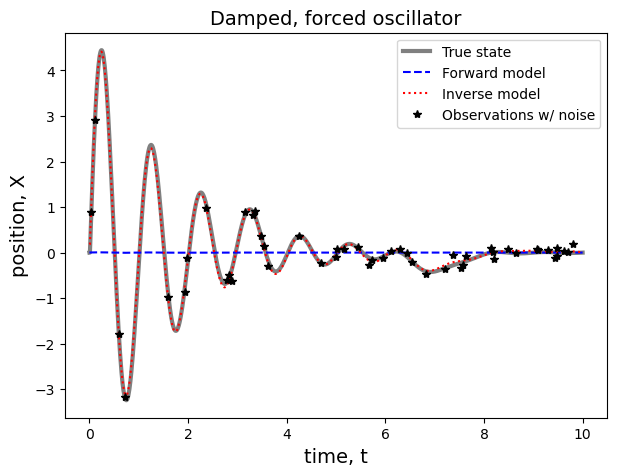

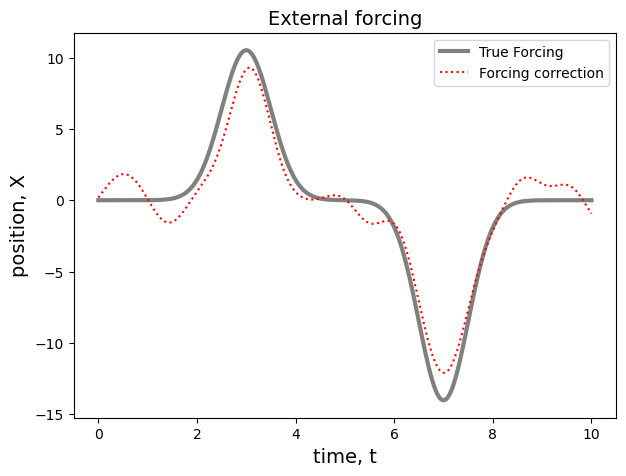

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define data covariance
#Cd=???? # YOUR CODE HERE
M = 50
Cd = (sigmaD**2) * np.eye(M)
Cd_inv = np.linalg.inv(Cd)

# Define forcing-error covariance
#Cf=??? # YOUR CODE HERE
Cf = np.zeros((N,N))
for n in range(N):
    for m in range(N):
        Cf[n,m] = sigmaF**2 * np.exp(-(t[n]-t[m])**2/(2*sigmaT**2))
# Assemble and solve forward and adjoint problem all at once
# YOUR CODE HERE
#xI=??? # YOUR CODE HERE
upper = np.concatenate((A, -Cf), axis=1)
lower = np.concatenate((L.T @ Cd_inv @ L, A.T), axis=1)
MM = np.concatenate((upper, lower), axis=0)

f0=f
b_top = f0
b_bottom = L.T @ Cd_inv @ d
b = np.concatenate((b_top, b_bottom))
# Compute forcing correction
# YOUR CODE HERE
solution = np.linalg.solve(MM, b)
xI = solution[:N]
lam = solution[N:]

fC = Cf @ lam

# Plot
fig = plt.figure(1,figsize=(7, 5), dpi=100)
plt.clf()
ax = fig.gca()
plt.plot(t,xT,'-',color='gray',label='True state',linewidth=3)
plt.plot(t,xF,'b--',label='Forward model')
plt.plot(t,xI,'r:',label='Inverse model')
plt.plot(to,d,'k*',label='Observations w/ noise',ms=6)
plt.title(r'Damped, forced oscillator', fontsize=14)
plt.xlabel('time, t', fontsize=14)
plt.ylabel('position, X', fontsize=14)

plt.legend(loc='upper right')

plt.show()

fig = plt.figure(2,figsize=(7, 5), dpi=100)
plt.clf()
ax = fig.gca()
plt.plot(t,fT,'-',color='gray',label='True Forcing',linewidth=3)
plt.plot(t,fC,'r:',label='Forcing correction')
plt.title(r'External forcing', fontsize=14)
plt.xlabel('time, t', fontsize=14)
plt.ylabel('position, X', fontsize=14)

plt.legend(loc='upper right')

plt.show()

